<a href="https://colab.research.google.com/github/changdaeoh/DACON_Dirty-MNIST/blob/main/0224_try.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 구글드라이브와 연동
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# common modules
import tensorflow as tf
from tensorflow import  keras

import numpy as np
import pandas as pd 
import random

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os
os.chdir('/content/drive/MyDrive/project_dataset/dacon_v2')

# 데이터 경로
train_dir = "/content/drive/MyDrive/project_dataset/dacon_v2/dirty_mnist_2nd"
test_dir = "/content/drive/MyDrive/project_dataset/dacon_v2/test_route"

# GPU 확인
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

SEED = 224
# global seed 고정
def seed_everything(seed = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    tf.random.set_seed(seed)

seed_everything(SEED)

Found GPU at: /device:GPU:0


## 1. 이전에 학습시킨 inception Resnet Dropout 성능 테스트해보기

# test data generate (augument / origin)

In [ ]:
test_sub = pd.read_csv('sample_submission.csv')
test_df = test_sub.copy()
test_df['index'] = test_sub['index'].apply(lambda x: str("{0:05d}".format(x))+'.png')





datagen = ImageDataGenerator(rescale=1./255.,
                             rotation_range = 10,
                             width_shift_range = 0.2,
                             height_shift_range = 0.2,
                             horizontal_flip = True,
                             vertical_flip = True,
                             validation_split = 0.1)

test_gen = ImageDataGenerator(rescale=1./255.)



test_gen = test_gen.flow_from_dataframe(dataframe = test_df,        
                                        directory='./test_route/test_dirty_mnist_2nd',       
                                        x_col='index',                             
                                        batch_size = 32,               
                                        shuffle = False,
                                        color_mode = "rgb",           
                                        class_mode = None,
                                        target_size=(256, 256))       

test_gen_ag = datagen.flow_from_dataframe(dataframe = test_df,        
                                        directory='./test_route/test_dirty_mnist_2nd',     
                                        x_col='index',                             
                                        batch_size = 32,               
                                        shuffle = False,
                                        color_mode = "rgb",           
                                        class_mode = None,
                                        target_size=(256, 256))       

Found 5000 validated image filenames.
Found 5000 validated image filenames.


In [ ]:
model = keras.models.load_model("./model/incepRes_dropout_decay.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 6, 6, 1536)        54336736  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1536)              0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 1536)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              1573888   
_________________________________________________________________
dropout_7 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_8 (Dropout)          (None, 512)              

# TTA

In [ ]:
batch_size = 32
tta_steps = 5
predictions = []
columns = list(test_df.columns[1:])
filename = "incepres_dropout_0223_TTA.csv"

for i in range(tta_steps):

    preds = model.predict_generator(generator = test_gen_ag,
                                    steps = 5000//batch_size)
    predictions.append(preds)

# 평균을 통한 final prediction
pred = np.mean(predictions, axis=0)
pred_sub = pred.copy()

# get label
pred_sub = pred_sub.round()

# create DF
res = pd.DataFrame(pred_sub, columns = columns )
int_rest = res.astype(int)

In [ ]:
submit = pd.concat([test_sub.iloc[:,0],int_rest], axis = 1)

submit.to_csv(filename, index = False)

In [ ]:
# 모델 학습률 확인하기 
import keras.backend as K

print(K.eval(model.optimizer.lr))

0.00025


# 2. Try New strategy
* new model (inception resnet based)
  * use DO, BN both ? 
  * Very simple model ? (clf head의 표현력을 제한. 아래 CNN단이 더 많은것을 representation하게끔)
  * change activation
  * change LR scheduler (성능기반, 지수기반, 1-cycle)
* test time improvement (TTA & MC Dropout)

<br/>
해결과제 

* overfitting 해결
* 수렴속도 개선
* 한글 노이즈를 제껴버릴 수 있는 방법

## 2.1 data preparing


In [ ]:
meta_df = pd.read_csv('dirty_mnist_2nd_answer.csv')
meta_df['index'] = meta_df['index'].apply(lambda x: str("{0:05d}".format(x))+'.png')
columns = list(meta_df.columns[1:])


datagen = ImageDataGenerator(rescale=1./255.,
                             rotation_range = 10,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             horizontal_flip = True,
                             vertical_flip = True,
                             validation_split = 0.1)

# generator
train_gen = datagen.flow_from_dataframe(dataframe = meta_df,        
                                        directory = train_dir,       
                                        x_col='index',               
                                        y_col=columns,                
                                        batch_size = 32,               
                                        seed = SEED,
                                        color_mode = "rgb",           
                                        class_mode='raw',
                                        target_size=(256, 256),       
                                        subset='training')

valid_gen = datagen.flow_from_dataframe(dataframe = meta_df,        
                                        directory = train_dir,       
                                        x_col='index',               
                                        y_col=columns,                
                                        batch_size = 32,               
                                        seed = SEED,
                                        color_mode = "rgb",           
                                        class_mode='raw',
                                        target_size=(256, 256),       
                                        subset='validation')

Found 45000 validated image filenames.
Found 5000 validated image filenames.


## 2.2 model build

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(
    include_top = False,
    weights = None,
    input_shape = (256, 256, 3)
)

In [ ]:
model = keras.models.Sequential()

model.add(base_model)
model.add(keras.layers.GlobalAveragePooling2D())
model.add(keras.layers.Dense(1536, activation='sigmoid'))
model.add(keras.layers.Dense(26, activation='sigmoid'))

BAcc = keras.metrics.BinaryAccuracy(name='binary_accuracy')
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)

model.compile(optimizer = optimizer, loss = "binary_crossentropy", metrics = [BAcc])

In [ ]:
def scheduler(epoch, lr):
    # lr = 0.96 * lr for every 4 epochs
    if not epoch:
        return lr
    elif not (epoch % 4):
        return 0.96 * lr
    else:
        return lr

## 2.3 fitting

In [ ]:
# callbacks
checkpoint = keras.callbacks.ModelCheckpoint('./model/incepres_vanilla.h5', 
                                             save_best_only=True, verbose=1,
                                             mode = "min",monitor = "val_loss")
early_stop_cb = keras.callbacks.EarlyStopping(patience = 10, restore_best_weights = True,
                                              mode = "min",monitor = "val_loss")
lr_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)


# fitting
history = model.fit(train_gen, epochs = 50, 
                       validation_data = valid_gen, 
                       callbacks = [checkpoint, early_stop_cb, lr_callback])

Epoch 1/50
1407/1407 [==============================] - 13904s 10s/step - loss: 0.6991 - binary_accuracy: 0.5272 - val_loss: 0.7058 - val_binary_accuracy: 0.5077

Epoch 00001: val_loss improved from inf to 0.70577, saving model to ./model/incepres_vanilla.h5
Epoch 2/50
1407/1407 [==============================] - 727s 516ms/step - loss: 0.6799 - binary_accuracy: 0.5606 - val_loss: 0.6816 - val_binary_accuracy: 0.5570

Epoch 00002: val_loss improved from 0.70577 to 0.68157, saving model to ./model/incepres_vanilla.h5
Epoch 3/50
1407/1407 [==============================] - 726s 516ms/step - loss: 0.6706 - binary_accuracy: 0.5779 - val_loss: 0.6770 - val_binary_accuracy: 0.5667

Epoch 00003: val_loss improved from 0.68157 to 0.67704, saving model to ./model/incepres_vanilla.h5
Epoch 4/50
1407/1407 [==============================] - 728s 517ms/step - loss: 0.6623 - binary_accuracy: 0.5917 - val_loss: 0.6576 - val_binary_accuracy: 0.6023

Epoch 00004: val_loss improved from 0.67704 to 0.657

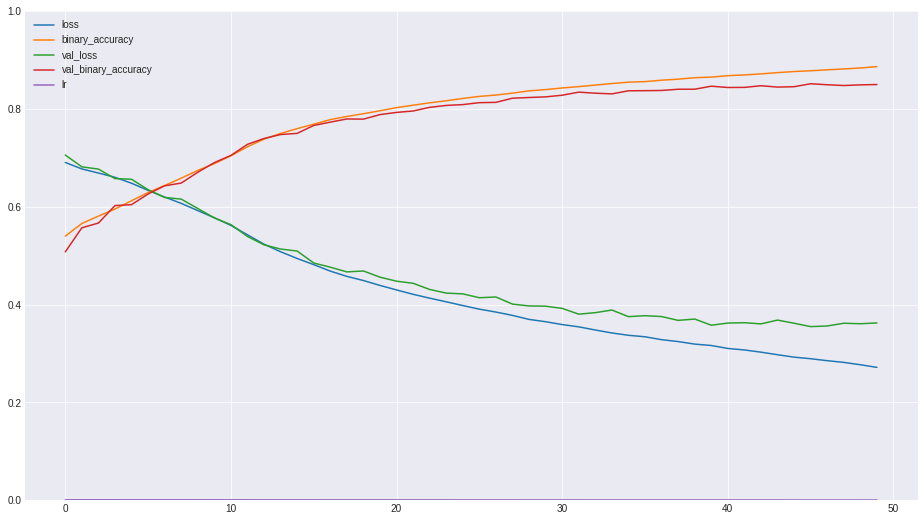

In [ ]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-dark")

pd.DataFrame(history.history).plot(figsize = (16, 9))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

## 2.4 TTA prediction 

In [ ]:
test_submit = pd.read_csv('sample_submission.csv')
test_df = test_submit.copy()
test_df['index'] = test_submit['index'].apply(lambda x: str("{:0>5d}".format(x))+'.png')

# TTA
test_gen_ag = ImageDataGenerator(rescale=1./255.,
                              rotation_range = 10,
                              width_shift_range = 0.1,
                              height_shift_range = 0.1,
                              horizontal_flip = True,
                              vertical_flip = True,
                              fill_mode = "nearest")

test_generator_ag = test_gen_ag.flow_from_dataframe(dataframe = test_df,        
                                        directory='./test_route/test_dirty_mnist_2nd',      
                                        x_col='index',                             
                                        batch_size = 32,               
                                        shuffle = False,
                                        color_mode = "rgb",           
                                        class_mode=None,
                                        target_size=(256, 256))

batch_size = 32
tta_steps = 30
predictions = []
columns = list(test_df.columns[1:])
filename = "incepRes_0224_v1_TTA.csv"

# 에폭 40까지 중 best Dense 
model = keras.models.load_model("./model/incepres_vanilla.h5")

for i in range(tta_steps):
    print("iter {}".format(i))
    preds = model.predict_generator(generator = test_generator_ag,
                                    steps = 5000 // batch_size, verbose = 1)
    predictions.append(preds)

# 평균을 통한 final prediction
pred = np.mean(predictions, axis=0)
pred_sub = pred.copy()

# get label
pred_sub = pred_sub.round()

# create DF
res = pd.DataFrame(pred_sub, columns = columns )
int_rest = res.astype(int)
submit = pd.concat([test_submit.iloc[:,0],int_rest], axis = 1)

submit.to_csv(filename, index = False)

Found 5000 validated image filenames.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


156/156 [==============================] - 63s 401ms/step


## 2.5 데이터 추가사용

In [ ]:
datagen2 = ImageDataGenerator(rescale=1./255.,
                             rotation_range = 10,
                             width_shift_range = 0.1,
                             height_shift_range = 0.1,
                             horizontal_flip = True,
                             vertical_flip = True,
                             validation_split = 0.02)

# generator
train_gen2 = datagen2.flow_from_dataframe(dataframe = meta_df,        
                                        directory = train_dir,       
                                        x_col='index',               
                                        y_col=columns,                
                                        batch_size = 32,               
                                        seed = 43,
                                        color_mode = "rgb",           
                                        class_mode='raw',
                                        target_size=(256, 256),       
                                        subset='training')

valid_gen2 = datagen2.flow_from_dataframe(dataframe = meta_df,        
                                        directory = train_dir,       
                                        x_col='index',               
                                        y_col=columns,                
                                        batch_size = 32,               
                                        seed = 43,
                                        color_mode = "rgb",           
                                        class_mode='raw',
                                        target_size=(256, 256),       
                                        subset='validation')

Found 49000 validated image filenames.
Found 1000 validated image filenames.


In [ ]:
# 모델 학습률 확인하기 
import keras.backend as K

print(K.eval(model.optimizer.lr))

0.0006382393


In [ ]:
checkpoint2 = keras.callbacks.ModelCheckpoint('./model/incepres_vanilla_add.h5', 
                                             save_best_only=True, verbose=1,
                                             mode = "min",monitor = "val_loss")


# fitting
history2 = model.fit(train_gen2, epochs = 30, 
                    validation_data = valid_gen2, 
                     callbacks = [checkpoint2, early_stop_cb, lr_callback])

Epoch 1/30
1532/1532 [==============================] - 753s 477ms/step - loss: 0.2175 - binary_accuracy: 0.9122 - val_loss: 0.2892 - val_binary_accuracy: 0.8833

Epoch 00001: val_loss improved from inf to 0.28923, saving model to ./model/incepres_vanilla_add.h5
Epoch 2/30
1532/1532 [==============================] - 730s 476ms/step - loss: 0.2096 - binary_accuracy: 0.9154 - val_loss: 0.2914 - val_binary_accuracy: 0.8866

Epoch 00002: val_loss did not improve from 0.28923
Epoch 3/30
1532/1532 [==============================] - 729s 476ms/step - loss: 0.2026 - binary_accuracy: 0.9186 - val_loss: 0.2898 - val_binary_accuracy: 0.8846

Epoch 00003: val_loss did not improve from 0.28923
Epoch 4/30
1532/1532 [==============================] - 729s 476ms/step - loss: 0.1971 - binary_accuracy: 0.9210 - val_loss: 0.2918 - val_binary_accuracy: 0.8860

Epoch 00004: val_loss did not improve from 0.28923
Epoch 5/30
1532/1532 [==============================] - 730s 476ms/step - loss: 0.1897 - binary

In [ ]:
test_submit = pd.read_csv('sample_submission.csv')
test_df = test_submit.copy()
test_df['index'] = test_submit['index'].apply(lambda x: str("{:0>5d}".format(x))+'.png')

# TTA
test_gen_ag = ImageDataGenerator(rescale=1./255.,
                              rotation_range = 10,
                              width_shift_range = 0.1,
                              height_shift_range = 0.1,
                              horizontal_flip = True,
                              vertical_flip = True,
                              fill_mode = "nearest")

test_generator_ag = test_gen_ag.flow_from_dataframe(dataframe = test_df,        
                                        directory='./test_route/test_dirty_mnist_2nd',      
                                        x_col='index',                             
                                        batch_size = 32,               
                                        shuffle = False,
                                        color_mode = "rgb",           
                                        class_mode=None,
                                        target_size=(256, 256))

batch_size = 32
tta_steps = 10
predictions = []
columns = list(test_df.columns[1:])
filename = "incepRes_0224_v2_TTA.csv"

# 에폭 40까지 중 best Dense 
model = keras.models.load_model("./model/incepres_vanilla_add.h5")

for i in range(tta_steps):
    print("iteration : {}".format(i+1))
    preds = model.predict_generator(generator = test_generator_ag,
                                    steps = 5000 // batch_size, verbose = 1)
    predictions.append(preds)

# 평균을 통한 final prediction
pred = np.mean(predictions, axis=0)
pred_sub = pred.copy()

# get label
pred_sub = pred_sub.round()

# create DF
res = pd.DataFrame(pred_sub, columns = columns )
int_rest = res.astype(int)
submit = pd.concat([test_submit.iloc[:,0],int_rest], axis = 1)

submit.to_csv(filename, index = False)

Found 5000 validated image filenames.
iteration : 0


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


156/156 [==============================] - 1169s 8s/step
iteration : 1
156/156 [==============================] - 75s 478ms/step
iteration : 2
156/156 [==============================] - 74s 477ms/step
iteration : 3
156/156 [==============================] - 75s 478ms/step
iteration : 4
156/156 [==============================] - 75s 480ms/step
iteration : 5
156/156 [==============================] - 74s 477ms/step
iteration : 6
156/156 [==============================] - 75s 479ms/step
iteration : 7
156/156 [==============================] - 74s 477ms/step
iteration : 8
156/156 [==============================] - 76s 485ms/step
iteration : 9
156/156 [==============================] - 74s 476ms/step
